# 3-D Plot of the US Treasury yield curve

- Author: Ian Blaiklock
- Date: 3/25/2015
- Note: Based on The Upshot's (NY Times) 3/18/2015 [post](http://www.nytimes.com/interactive/2015/03/19/upshot/3d-yield-curve-economic-growth.html?abt=0002&abg=1) titled 'A 3-D View of a Chart That Predicts The Economic Future: The Yield Curve' by Gregor Aisch and Amanda Cox.

The US Treasury yield curve represents the relationship between maturity and yields. For more info see http://en.wikipedia.org/wiki/Yield_curve.

The typical plot of historical yield curves is 2-D where the user has to pick various reference points over time. However, without always knowing how the curve has changed over time selecting those points is often difficult.

The Upshot used yields on treasuries since 1990 and plotted the yield curve as a time series in 3-D. I thought that the result was the coolest thing and set out to do the same thing using Python.

I used [Quandl](https://www.quandl.com/data/USTREASURY/YIELD-Treasury-Yield-Curve-Rates) as the link between my script and the Treasury's [data](http://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yieldAll).

Some helpful links along the way include:

- Matplotlib's mplot3d surface plot [tutorial](http://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html#surface-plots)
- Matplotlib [dates](http://matplotlib.org/api/dates_api.html)
- SciPy's numpy array creation routines [reference](http://docs.scipy.org/doc/numpy/reference/routines.array-creation.html)

### Preliminaries

In [1]:
# Python3.9.9
%matplotlib inline
import quandl
import numpy as np
from mpl_toolkits.mplot3d import axes3d

import matplotlib.dates as dates
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

### Quandl

We aren't doing anything super special to get data from Quandl. Once we have the series name, `USTREASURY/YIELD`, it is a simple call using Quandl's `.get` method. 

Since I was following the mplot3d tutorial I decided to return the data as a numpy `recarray`, which is not the default return format. 

The `.get` method also makes it really easy to select a specific date range using `trim_start` and `trim_end`. The US Treasury data starts on 1990-01-02.

In [2]:
# data = quandl.get('USTREASURY/YIELD', returns='numpy', trim_start="2021-01-01")
data = quandl.get('USTREASURY/YIELD', returns='numpy', trim_start="2022-06-01")

A quick look at the data

In [3]:
data

rec.array([('2022-06-01T00:00:00.000000000', 0.77, 0.9 , 1.15, 1.63, 2.16, 2.66, 2.84, 2.94, 2.98, 2.94, 3.31, 3.09),
           ('2022-06-02T00:00:00.000000000', 0.85, 1.05, 1.17, 1.64, 2.15, 2.65, 2.83, 2.92, 2.95, 2.92, 3.3 , 3.09),
           ('2022-06-03T00:00:00.000000000', 0.87, 1.05, 1.21, 1.68, 2.18, 2.66, 2.87, 2.95, 2.99, 2.96, 3.33, 3.11),
           ('2022-06-06T00:00:00.000000000', 0.88, 1.07, 1.26, 1.74, 2.23, 2.73, 2.94, 3.03, 3.07, 3.04, 3.41, 3.19),
           ('2022-06-07T00:00:00.000000000', 0.87, 1.08, 1.26, 1.75, 2.26, 2.75, 2.91, 2.99, 3.02, 2.98, 3.35, 3.13),
           ('2022-06-08T00:00:00.000000000', 0.89, 1.1 , 1.28, 1.77, 2.29, 2.78, 2.94, 3.03, 3.06, 3.03, 3.4 , 3.18),
           ('2022-06-09T00:00:00.000000000', 1.05, 1.17, 1.3 , 1.81, 2.35, 2.83, 2.99, 3.07, 3.08, 3.04, 3.4 , 3.18),
           ('2022-06-10T00:00:00.000000000', 1.1 , 1.25, 1.39, 1.98, 2.58, 3.06, 3.21, 3.25, 3.24, 3.15, 3.45, 3.2 ),
           ('2022-06-13T00:00:00.000000000', 1.13, 1.45,

### Transforming the data
In order to use matplotlib's `surface_plot` function (*or at least mimic the tutorial*) we need 3 numpy arrays. The `x` array will consist of the dates, the `y` array will consist of maturities and the `z` array will consist of the yields.

Before we dig in building any arrays we need to convert the header row (strings) received from Quandl into actual floating point numbers.

In [4]:
# Header row from Quandl
print(data.dtype.names)

('Date', '1 MO', '2 MO', '3 MO', '6 MO', '1 YR', '2 YR', '3 YR', '5 YR', '7 YR', '10 YR', '20 YR', '30 YR')


In [5]:
# Conversion
header = []
for name in data.dtype.names[1:]:
    maturity = float(name.split(" ")[0])
    if name.split(" ")[1] == 'Mo':
        maturity = maturity / 12
    header.append(maturity)
print(header)

[1.0, 2.0, 3.0, 6.0, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 20.0, 30.0]


My (*probably inefficient*) plan for building the arrays is to convert the `recarray` received from Quandl into lists in order to element-wise manipulation and then convert back into regular numpy arrays.

In [6]:
# Some empty lists
x_data = []; y_data = []; z_data = []

In [7]:
# Convert dates from datetime to numeric
for dt in data.Date:
    dt_num = dates.date2num(dt)
    x_data.append([dt_num for i in range(len(data.dtype.names)-1)])
print('x_data: ', x_data[1:5])

x_data:  [[19145.0, 19145.0, 19145.0, 19145.0, 19145.0, 19145.0, 19145.0, 19145.0, 19145.0, 19145.0, 19145.0, 19145.0], [19146.0, 19146.0, 19146.0, 19146.0, 19146.0, 19146.0, 19146.0, 19146.0, 19146.0, 19146.0, 19146.0, 19146.0], [19149.0, 19149.0, 19149.0, 19149.0, 19149.0, 19149.0, 19149.0, 19149.0, 19149.0, 19149.0, 19149.0, 19149.0], [19150.0, 19150.0, 19150.0, 19150.0, 19150.0, 19150.0, 19150.0, 19150.0, 19150.0, 19150.0, 19150.0, 19150.0]]


Each row of our `recarray` from Quandl is a tuple that consists of the date and then entries for each maturity. Our `z` array, which are the yields, needs to be extracted from those tuples.

In [8]:
# Extract yields from data
for row in data:
    y_data.append(header)
    z_data.append(list(row.tolist()[1:]))
print('y_data: ', y_data[1:10])
print('z_data: ', z_data[1:10])

y_data:  [[1.0, 2.0, 3.0, 6.0, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 20.0, 30.0], [1.0, 2.0, 3.0, 6.0, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 20.0, 30.0], [1.0, 2.0, 3.0, 6.0, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 20.0, 30.0], [1.0, 2.0, 3.0, 6.0, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 20.0, 30.0], [1.0, 2.0, 3.0, 6.0, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 20.0, 30.0], [1.0, 2.0, 3.0, 6.0, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 20.0, 30.0], [1.0, 2.0, 3.0, 6.0, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 20.0, 30.0], [1.0, 2.0, 3.0, 6.0, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 20.0, 30.0], [1.0, 2.0, 3.0, 6.0, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 20.0, 30.0]]
z_data:  [[0.85, 1.05, 1.17, 1.64, 2.15, 2.65, 2.83, 2.92, 2.95, 2.92, 3.3, 3.09], [0.87, 1.05, 1.21, 1.68, 2.18, 2.66, 2.87, 2.95, 2.99, 2.96, 3.33, 3.11], [0.88, 1.07, 1.26, 1.74, 2.23, 2.73, 2.94, 3.03, 3.07, 3.04, 3.41, 3.19], [0.87, 1.08, 1.26, 1.75, 2.26, 2.75, 2.91, 2.99, 3.02, 2.98, 3.35, 3.13], [0.89, 1.1, 1.28, 1.77, 2.29, 2.78, 2.94, 3.03, 3.06, 3.03, 3.4, 3.18], [1.05, 1.17, 1.3, 1.81, 2.35

### Build numpy arrays

In [9]:
x = np.array(x_data, dtype='f'); y = np.array(y_data, dtype='f'); z = np.array(z_data, dtype='f')

In [10]:
print('x:', x)
print('y: ', y)
print('z: ', z)

x: [[19144. 19144. 19144. ... 19144. 19144. 19144.]
 [19145. 19145. 19145. ... 19145. 19145. 19145.]
 [19146. 19146. 19146. ... 19146. 19146. 19146.]
 ...
 [19438. 19438. 19438. ... 19438. 19438. 19438.]
 [19439. 19439. 19439. ... 19439. 19439. 19439.]
 [19440. 19440. 19440. ... 19440. 19440. 19440.]]
y:  [[ 1.  2.  3. ... 10. 20. 30.]
 [ 1.  2.  3. ... 10. 20. 30.]
 [ 1.  2.  3. ... 10. 20. 30.]
 ...
 [ 1.  2.  3. ... 10. 20. 30.]
 [ 1.  2.  3. ... 10. 20. 30.]
 [ 1.  2.  3. ... 10. 20. 30.]]
z:  [[0.77 0.9  1.15 ... 2.94 3.31 3.09]
 [0.85 1.05 1.17 ... 2.92 3.3  3.09]
 [0.87 1.05 1.21 ... 2.96 3.33 3.11]
 ...
 [4.16 4.56 4.79 ... 3.48 3.83 3.68]
 [4.26 4.48 4.73 ... 3.38 3.78 3.66]
 [4.28 4.48 4.74 ... 3.38 3.77 3.64]]


### Plot the surface plot

The `format_date` function and method for rotating the x tick labels was modified from this [SO question](http://stackoverflow.com/questions/2195983/matplotlib-formatting-dates-on-the-x-axis-in-a-3d-bar-graph)

If you want to see a list of available colormaps use `print plt.colormaps()` or visit http://mpastell.com/2013/05/02/matplotlib_colormaps/.

In order for the colormap to scale the colors correctly (because of the presence of `NaN`s) set `vmin` and `vmax` to their respective min and max from the `z`, yield, array.

In [11]:
print(plt.colormaps())

['magma', 'inferno', 'plasma', 'viridis', 'cividis', 'twilight', 'twilight_shifted', 'turbo', 'Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap', 'GnBu', 'Greens', 'Greys', 'OrRd', 'Oranges', 'PRGn', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlGn', 'Reds', 'Spectral', 'Wistia', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd', 'afmhot', 'autumn', 'binary', 'bone', 'brg', 'bwr', 'cool', 'coolwarm', 'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_gray', 'gist_heat', 'gist_ncar', 'gist_rainbow', 'gist_stern', 'gist_yarg', 'gnuplot', 'gnuplot2', 'gray', 'hot', 'hsv', 'jet', 'nipy_spectral', 'ocean', 'pink', 'prism', 'rainbow', 'seismic', 'spring', 'summer', 'terrain', 'winter', 'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c', 'magma_r', 'inferno_r', 'plasma_r', 'viridis_r', 'cividis_r', 'twilight_r', 'twilight_shifted_r', 'turbo_r', 'Blues_r', 'BrBG_r', 'BuGn_r', 'BuPu_r', 'CMRmap_r', 'GnBu_r', 'G

/var/folders/6_/x9l7hy292211nnvbjnlnxt5r0000gn/T/ipykernel_5160/4066752693.py:15: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
/var/folders/6_/x9l7hy292211nnvbjnlnxt5r0000gn/T/ipykernel_5160/4066752693.py:16: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  for tl in ax.w_xaxis.get_ticklabels():


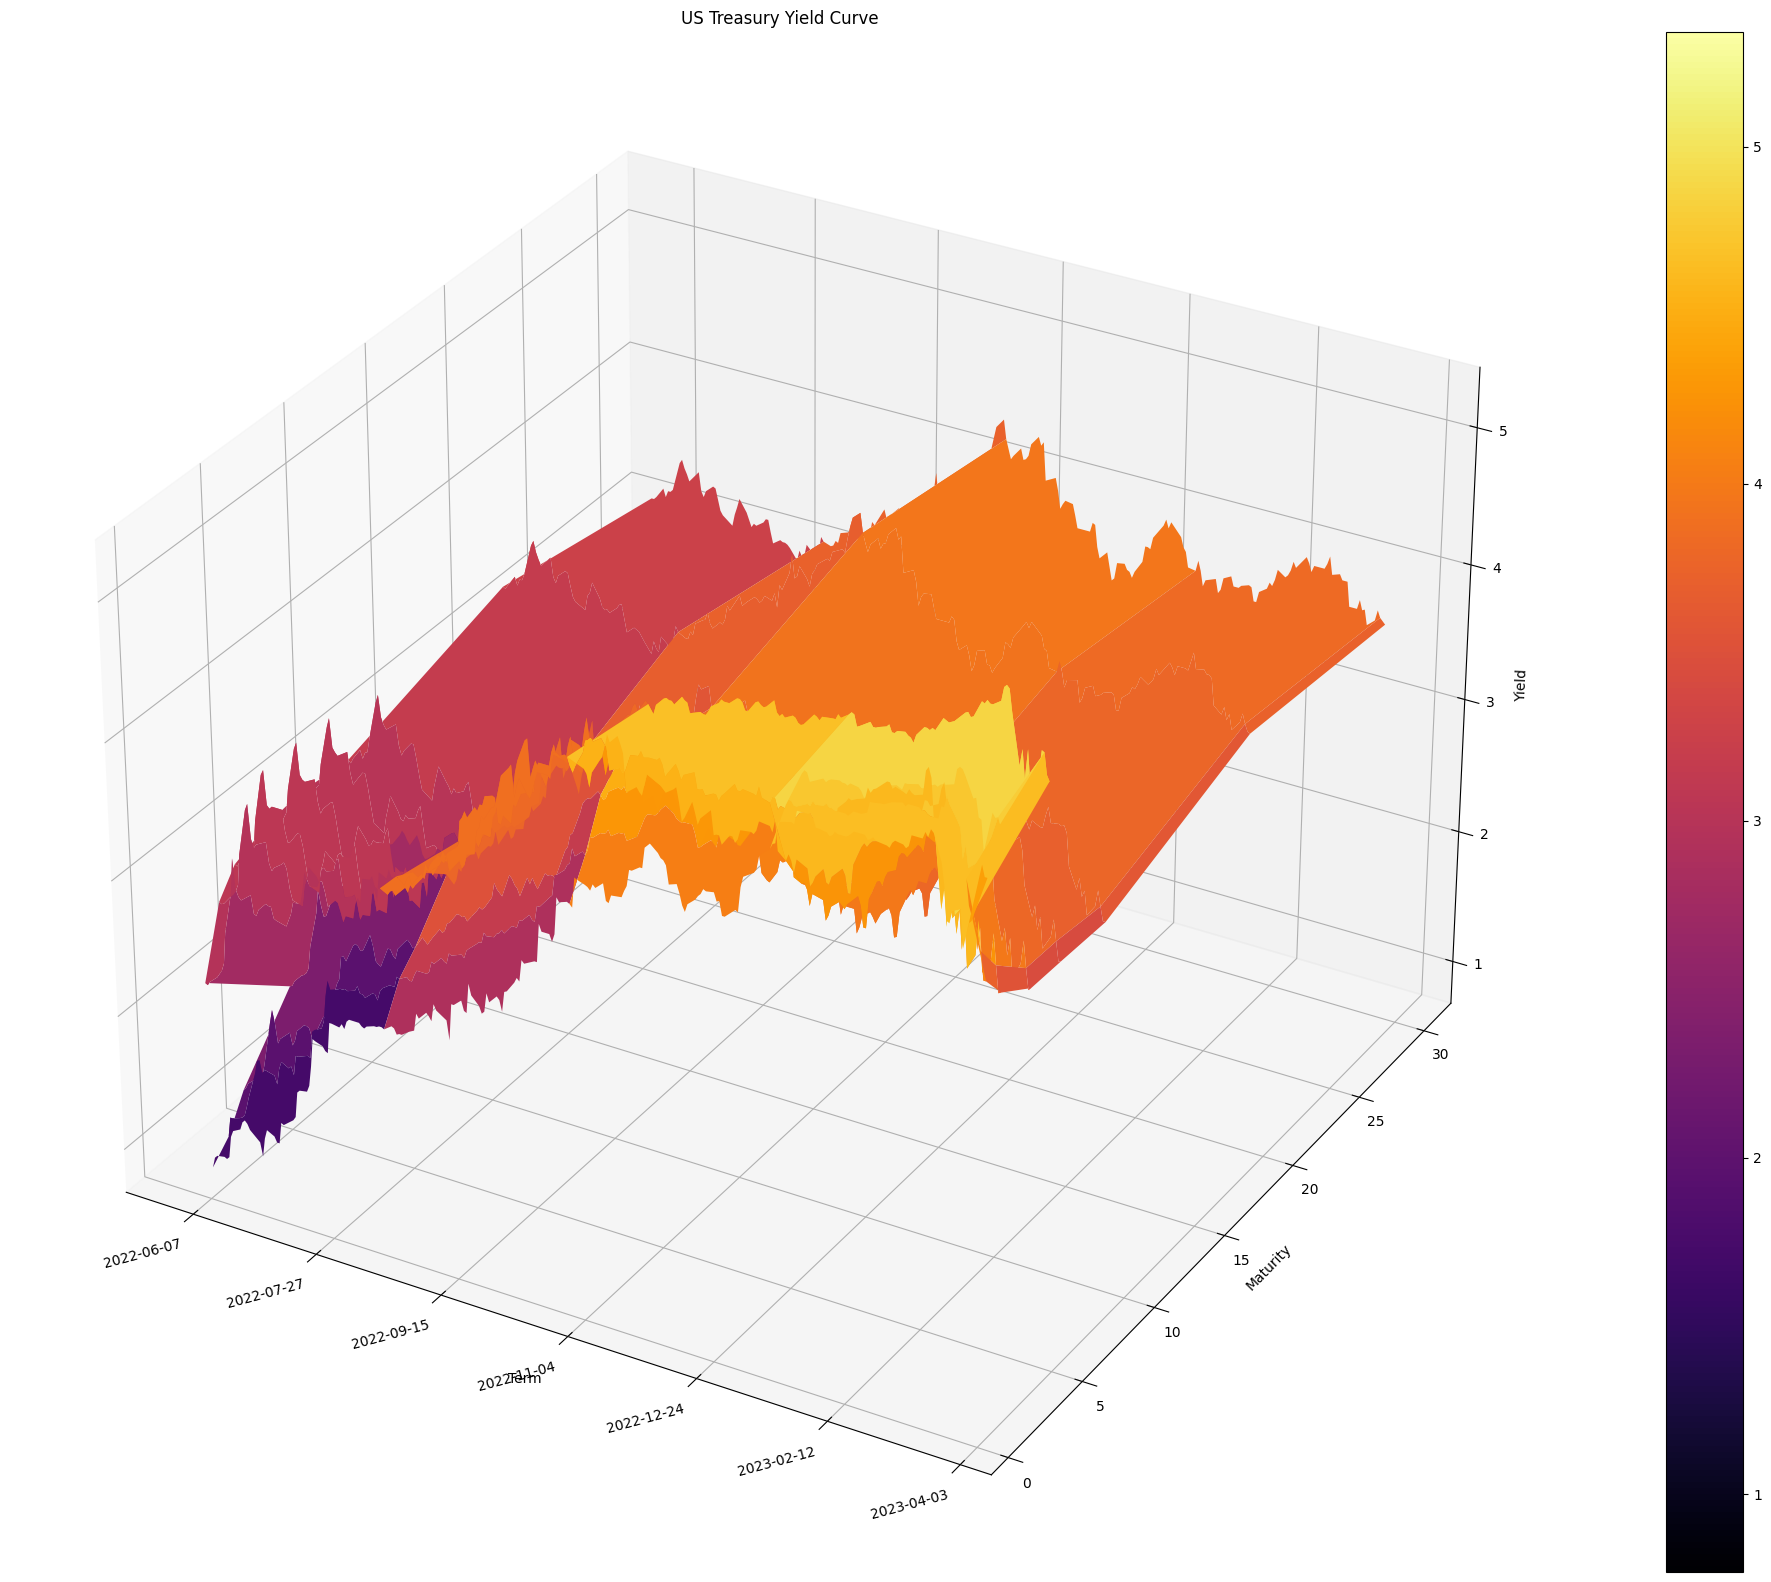

In [12]:
# 左が古い、右が最新
# fig = plt.figure(figsize=(15, 10))
fig = plt.figure(figsize=(30, 20))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, z, rstride=50, cstride=1, cmap='inferno', vmin=np.nanmin(z), vmax=np.nanmax(z))
ax.set_title('US Treasury Yield Curve')
ax.set_ylabel('Maturity')
ax.set_zlabel('Yield')
ax.set_xlabel('Term')
#ax.view_init(elev=230, azim=110)
# SO question
def format_date(x, pos=None):
     return dates.num2date(x).strftime('%Y-%m-%d')

ax.w_xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
for tl in ax.w_xaxis.get_ticklabels():
    tl.set_ha('right')
    tl.set_rotation(15)
fig.colorbar(surf)
plt.show()

/var/folders/6_/x9l7hy292211nnvbjnlnxt5r0000gn/T/ipykernel_5160/2404236148.py:15: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
/var/folders/6_/x9l7hy292211nnvbjnlnxt5r0000gn/T/ipykernel_5160/2404236148.py:16: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  for tl in ax.w_xaxis.get_ticklabels():


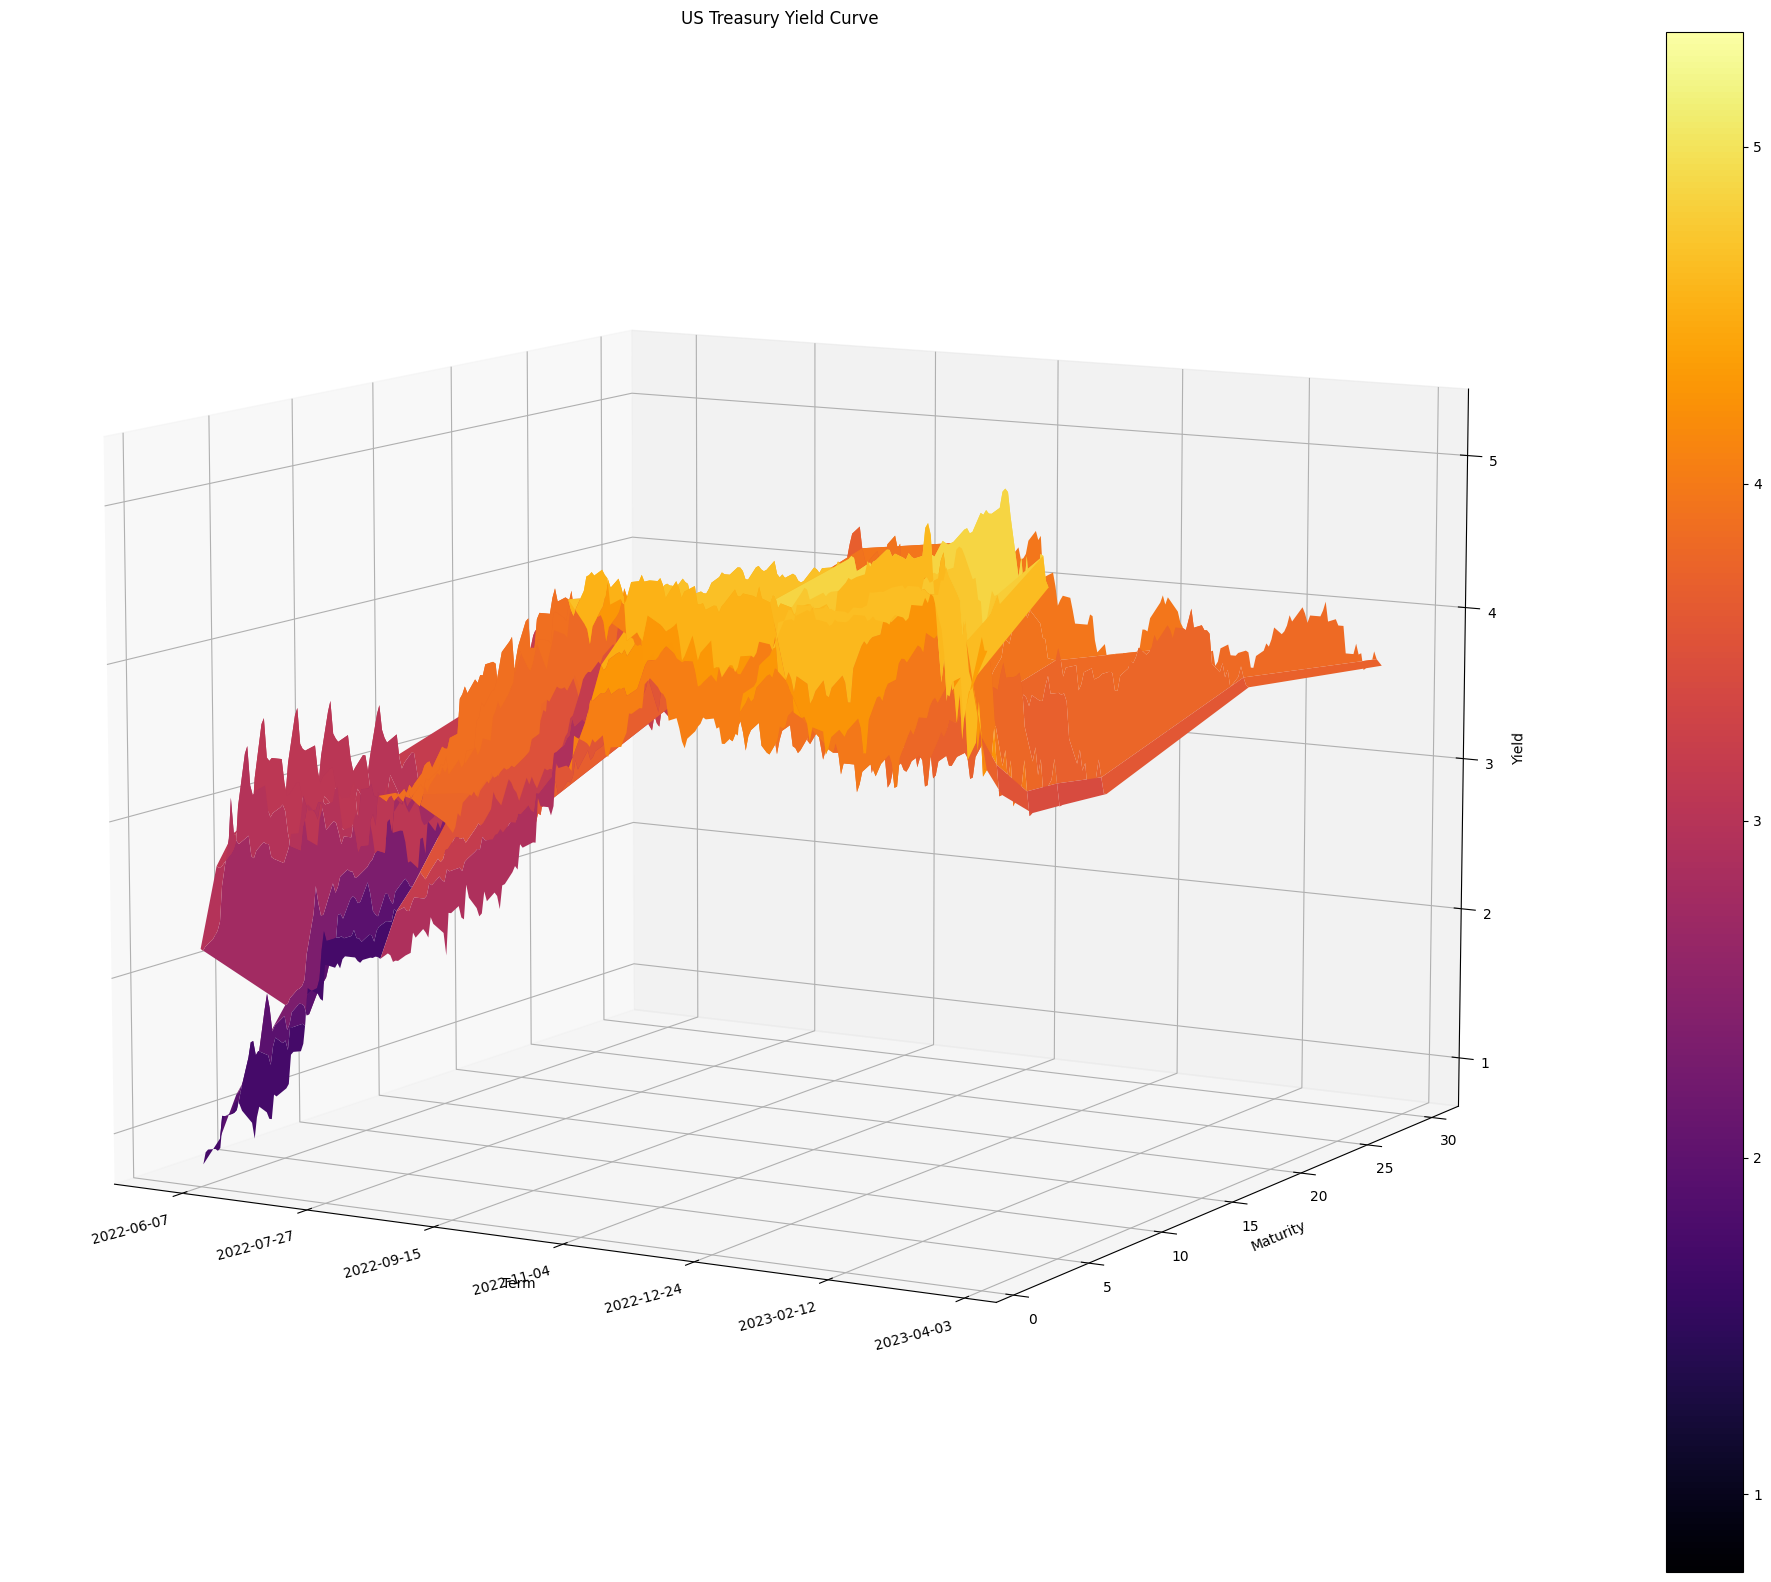

In [13]:
# 左が古い、右が最新
# fig = plt.figure(figsize=(15, 10))
fig = plt.figure(figsize=(30, 20))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, z, rstride=50, cstride=1, cmap='inferno', vmin=np.nanmin(z), vmax=np.nanmax(z))
ax.set_title('US Treasury Yield Curve')
ax.set_ylabel('Maturity')
ax.set_zlabel('Yield')
ax.set_xlabel('Term')
ax.view_init(elev=10 ,azim=300)
# SO question
def format_date(x, pos=None):
     return dates.num2date(x).strftime('%Y-%m-%d')

ax.w_xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
for tl in ax.w_xaxis.get_ticklabels():
    tl.set_ha('right')
    tl.set_rotation(15)
fig.colorbar(surf)
plt.show()

/var/folders/6_/x9l7hy292211nnvbjnlnxt5r0000gn/T/ipykernel_5160/2438405483.py:15: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
/var/folders/6_/x9l7hy292211nnvbjnlnxt5r0000gn/T/ipykernel_5160/2438405483.py:16: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  for tl in ax.w_xaxis.get_ticklabels():


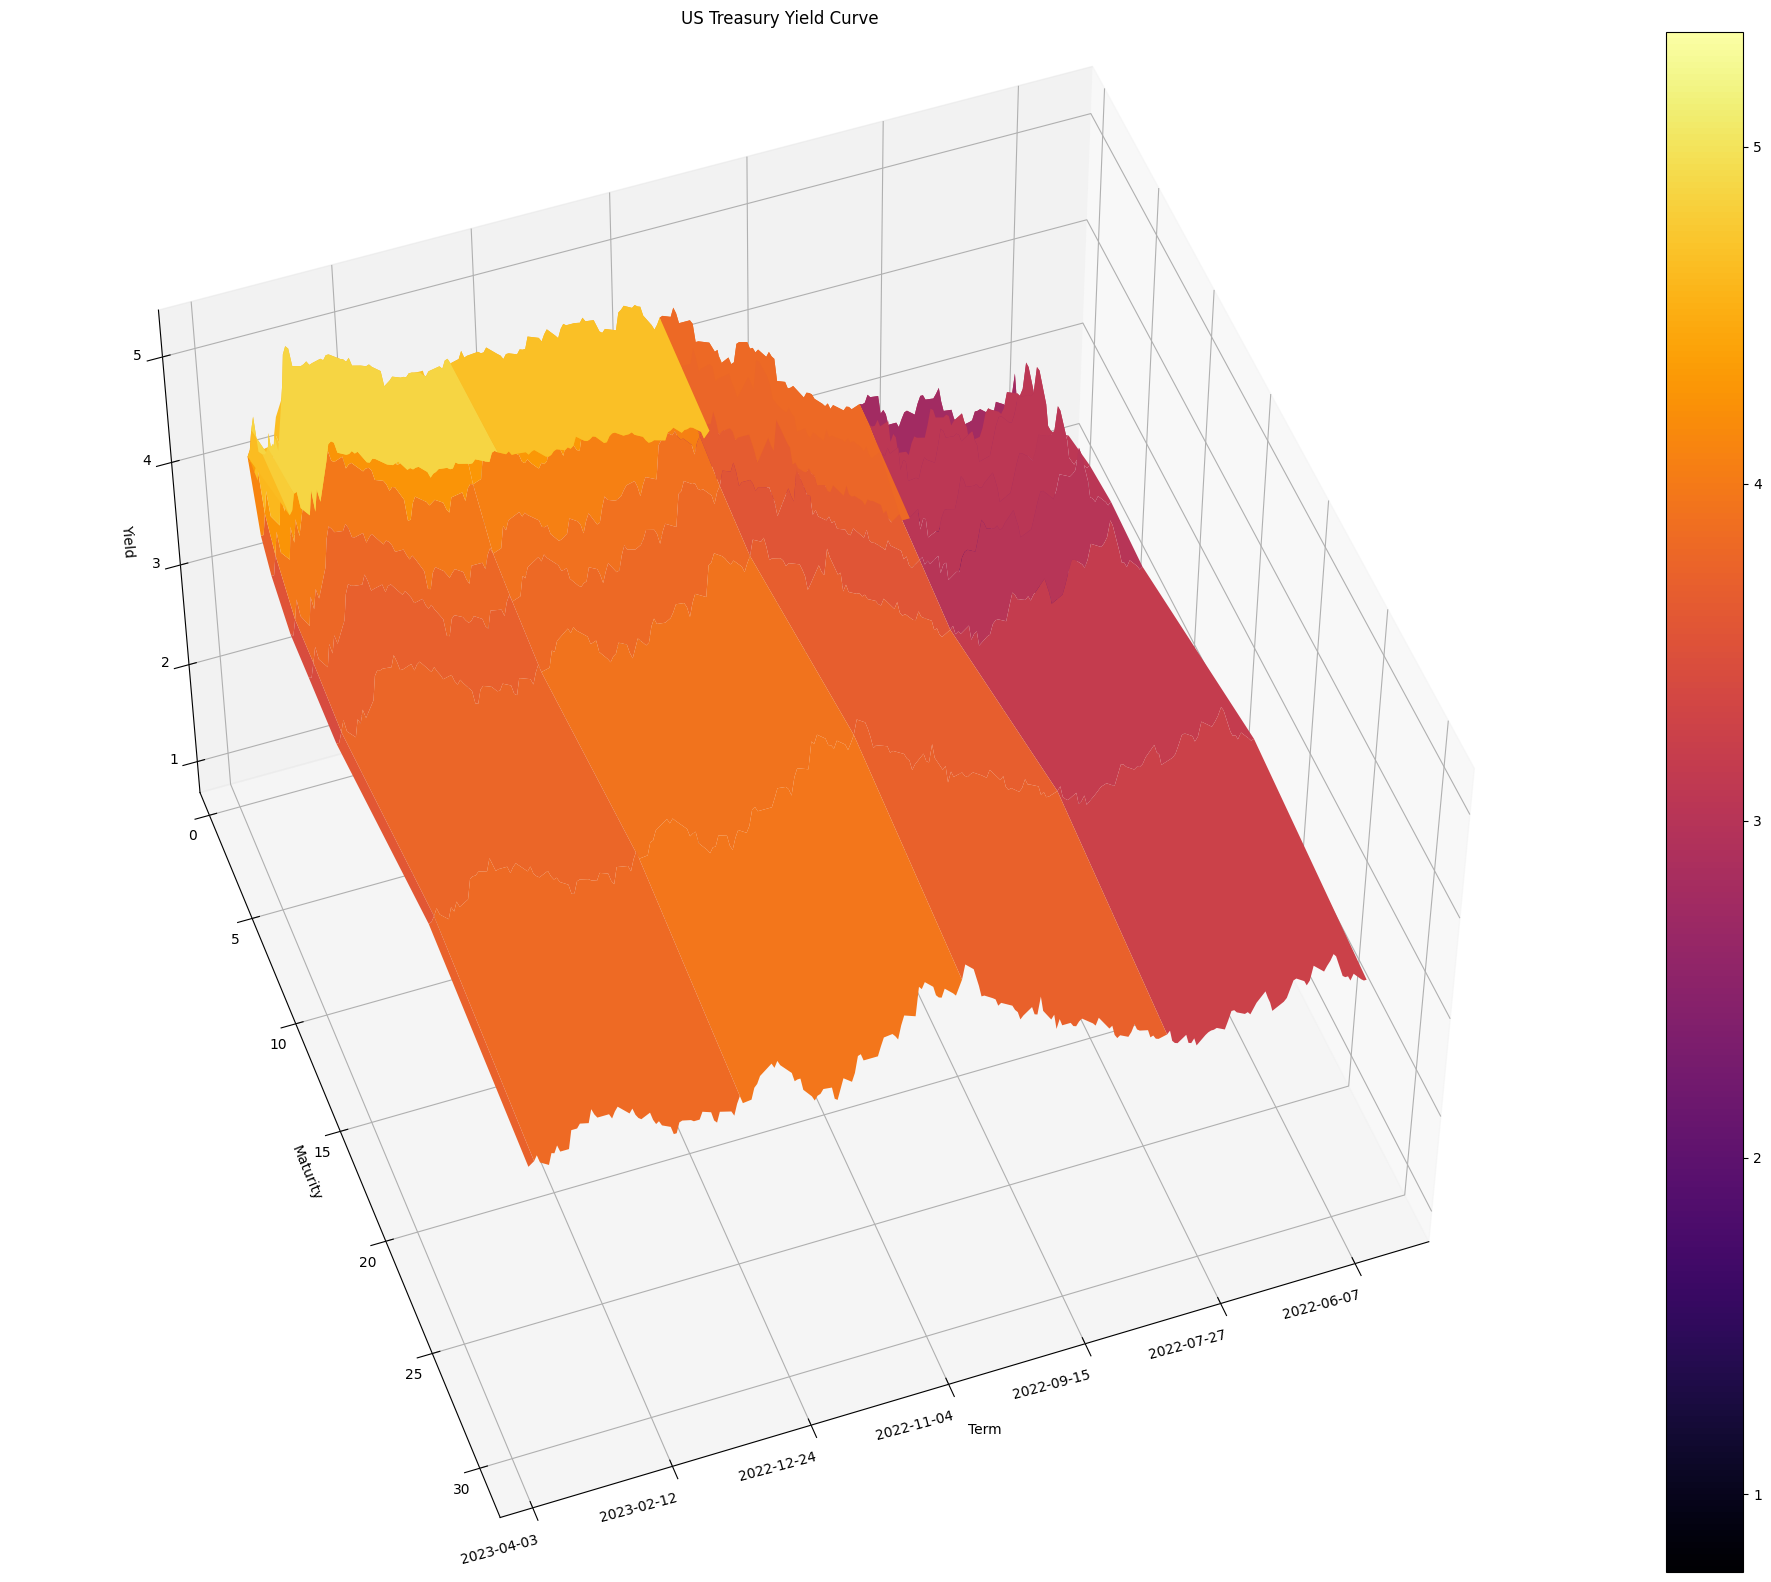

In [14]:
# 左が古い、右が最新
# fig = plt.figure(figsize=(15, 10))
fig = plt.figure(figsize=(30, 20))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, z, rstride=50, cstride=1, cmap='inferno', vmin=np.nanmin(z), vmax=np.nanmax(z))
ax.set_title('US Treasury Yield Curve')
ax.set_ylabel('Maturity')
ax.set_zlabel('Yield')
ax.set_xlabel('Term')
ax.view_init(elev=50 ,azim=70)
# SO question
def format_date(x, pos=None):
     return dates.num2date(x).strftime('%Y-%m-%d')

ax.w_xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
for tl in ax.w_xaxis.get_ticklabels():
    tl.set_ha('right')
    tl.set_rotation(15)
fig.colorbar(surf)
plt.show()

/var/folders/6_/x9l7hy292211nnvbjnlnxt5r0000gn/T/ipykernel_5160/1761639282.py:17: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
/var/folders/6_/x9l7hy292211nnvbjnlnxt5r0000gn/T/ipykernel_5160/1761639282.py:18: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  for tl in ax.w_xaxis.get_ticklabels():


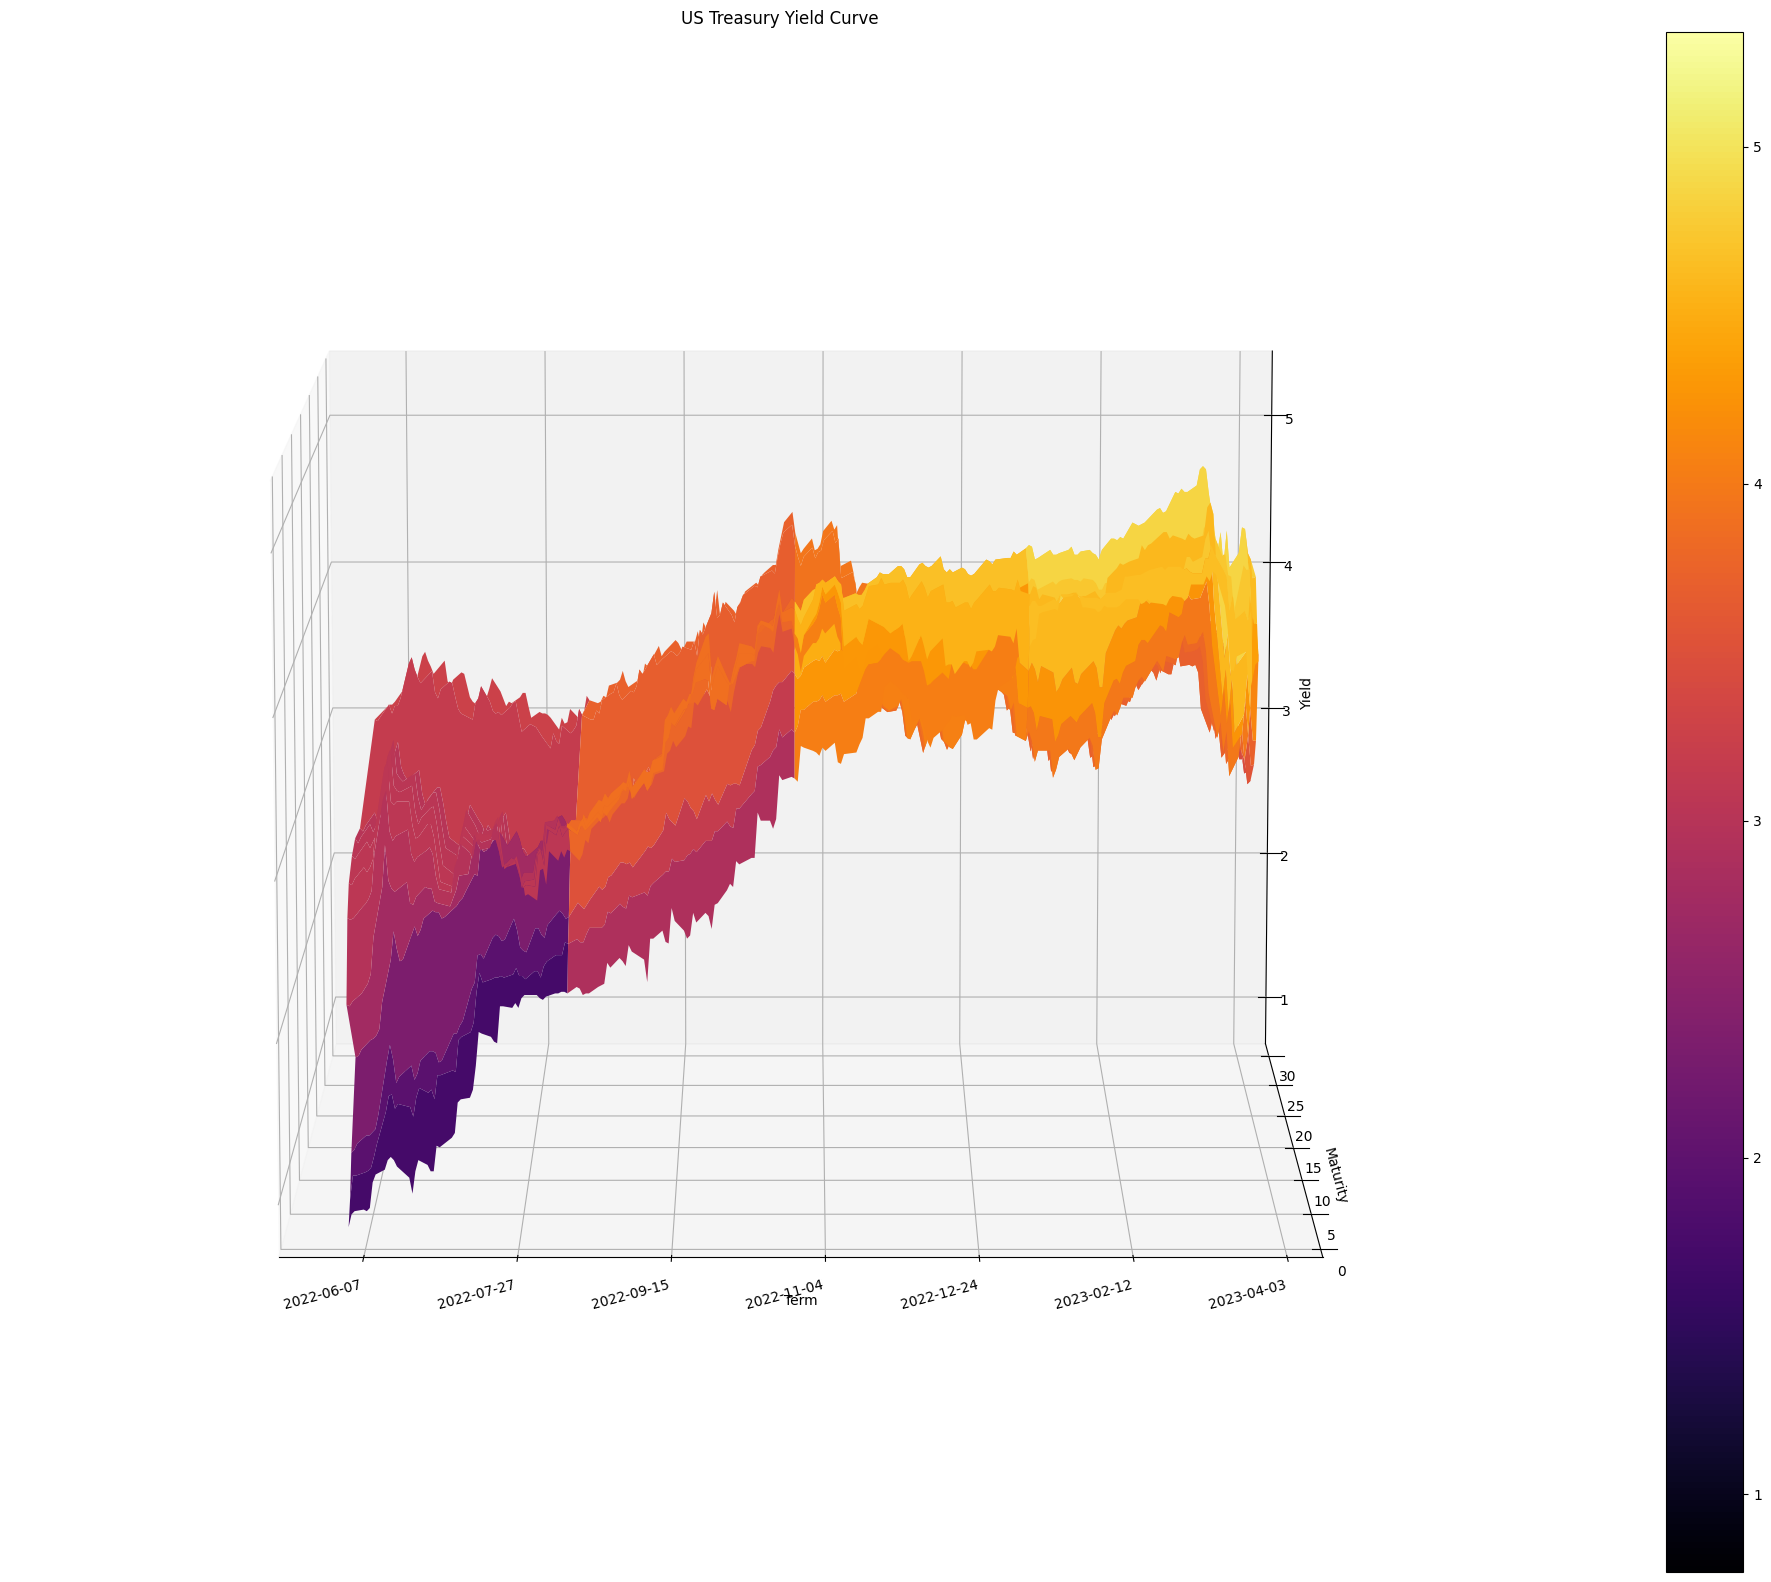

In [15]:
# 左が古い、右が最新
# fig = plt.figure(figsize=(15, 10))
fig = plt.figure(figsize=(30, 20))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, z, rstride=50, cstride=1, cmap='inferno', vmin=np.nanmin(z), vmax=np.nanmax(z))
ax.set_title('US Treasury Yield Curve')
ax.set_ylabel('Maturity')
ax.set_zlabel('Yield')
ax.set_xlabel('Term')
# elev y , azim x
ax.view_init(elev=10,azim=270 )
#ax.view_init(elev=230, azim=110)
# SO question
def format_date(x, pos=None):
     return dates.num2date(x).strftime('%Y-%m-%d')

ax.w_xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
for tl in ax.w_xaxis.get_ticklabels():
    tl.set_ha('right')
    tl.set_rotation(15)
fig.colorbar(surf)
plt.show()

/var/folders/6_/x9l7hy292211nnvbjnlnxt5r0000gn/T/ipykernel_5160/1442269314.py:17: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
/var/folders/6_/x9l7hy292211nnvbjnlnxt5r0000gn/T/ipykernel_5160/1442269314.py:18: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  for tl in ax.w_xaxis.get_ticklabels():


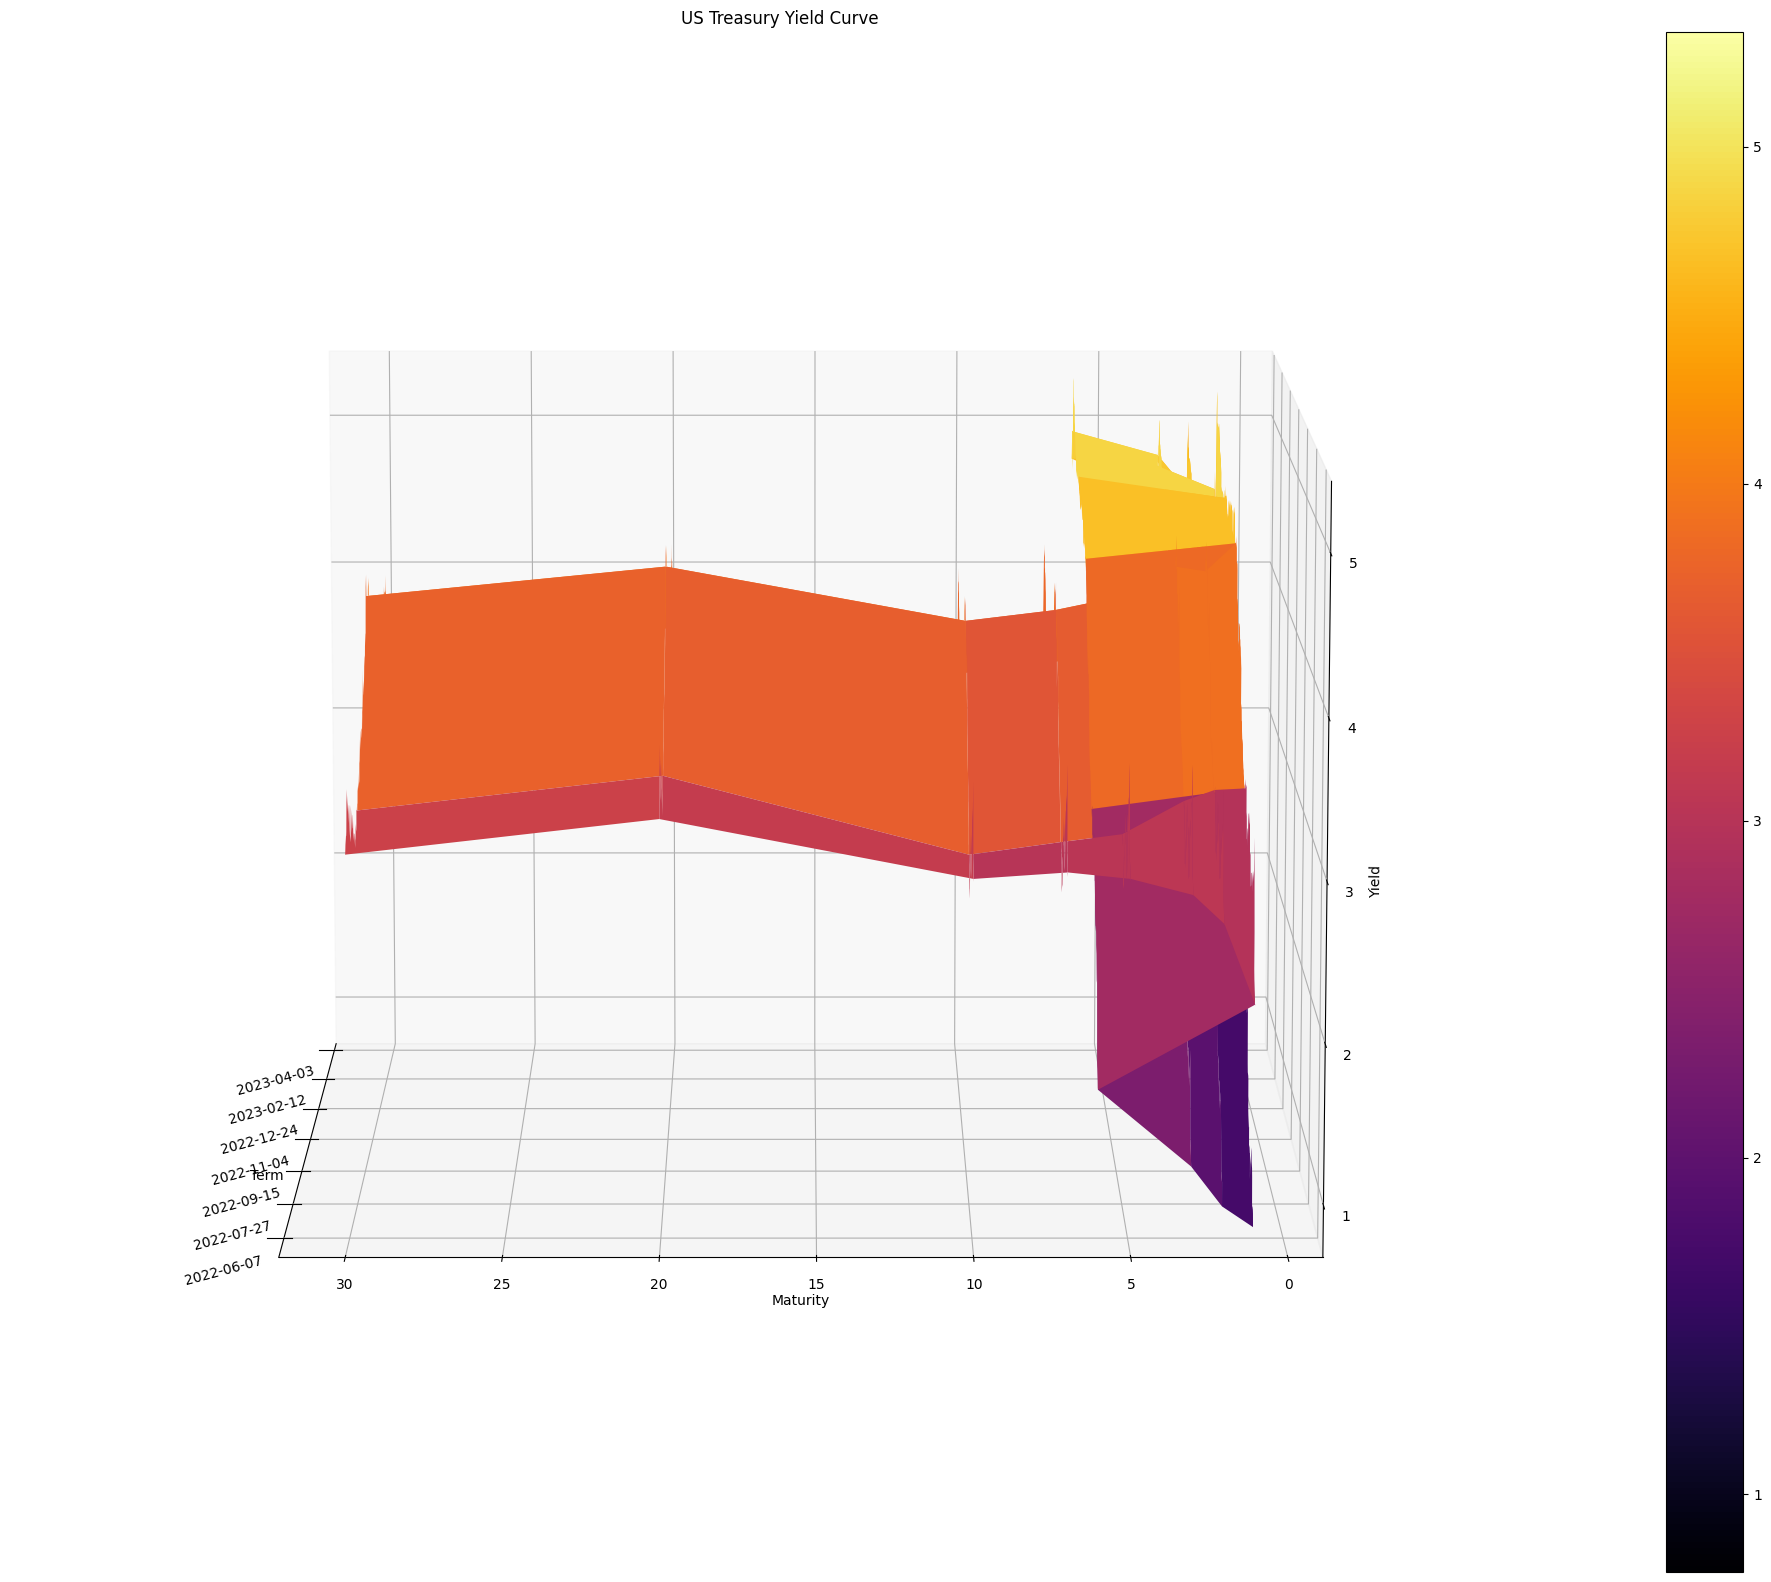

In [16]:
# 手前が古い、奥が最新
# fig = plt.figure(figsize=(15, 10))
fig = plt.figure(figsize=(30, 20))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, z, rstride=50, cstride=1, cmap='inferno', vmin=np.nanmin(z), vmax=np.nanmax(z))
ax.set_title('US Treasury Yield Curve')
ax.set_ylabel('Maturity')
ax.set_zlabel('Yield')
ax.set_xlabel('Term')
# elev y , azim x
ax.view_init(elev=10,azim=180 )
#ax.view_init(elev=230, azim=110)
# SO question
def format_date(x, pos=None):
     return dates.num2date(x).strftime('%Y-%m-%d')

ax.w_xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
for tl in ax.w_xaxis.get_ticklabels():
    tl.set_ha('right')
    tl.set_rotation(15)
fig.colorbar(surf)
plt.show()

/var/folders/6_/x9l7hy292211nnvbjnlnxt5r0000gn/T/ipykernel_5160/2229302839.py:17: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
/var/folders/6_/x9l7hy292211nnvbjnlnxt5r0000gn/T/ipykernel_5160/2229302839.py:18: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  for tl in ax.w_xaxis.get_ticklabels():


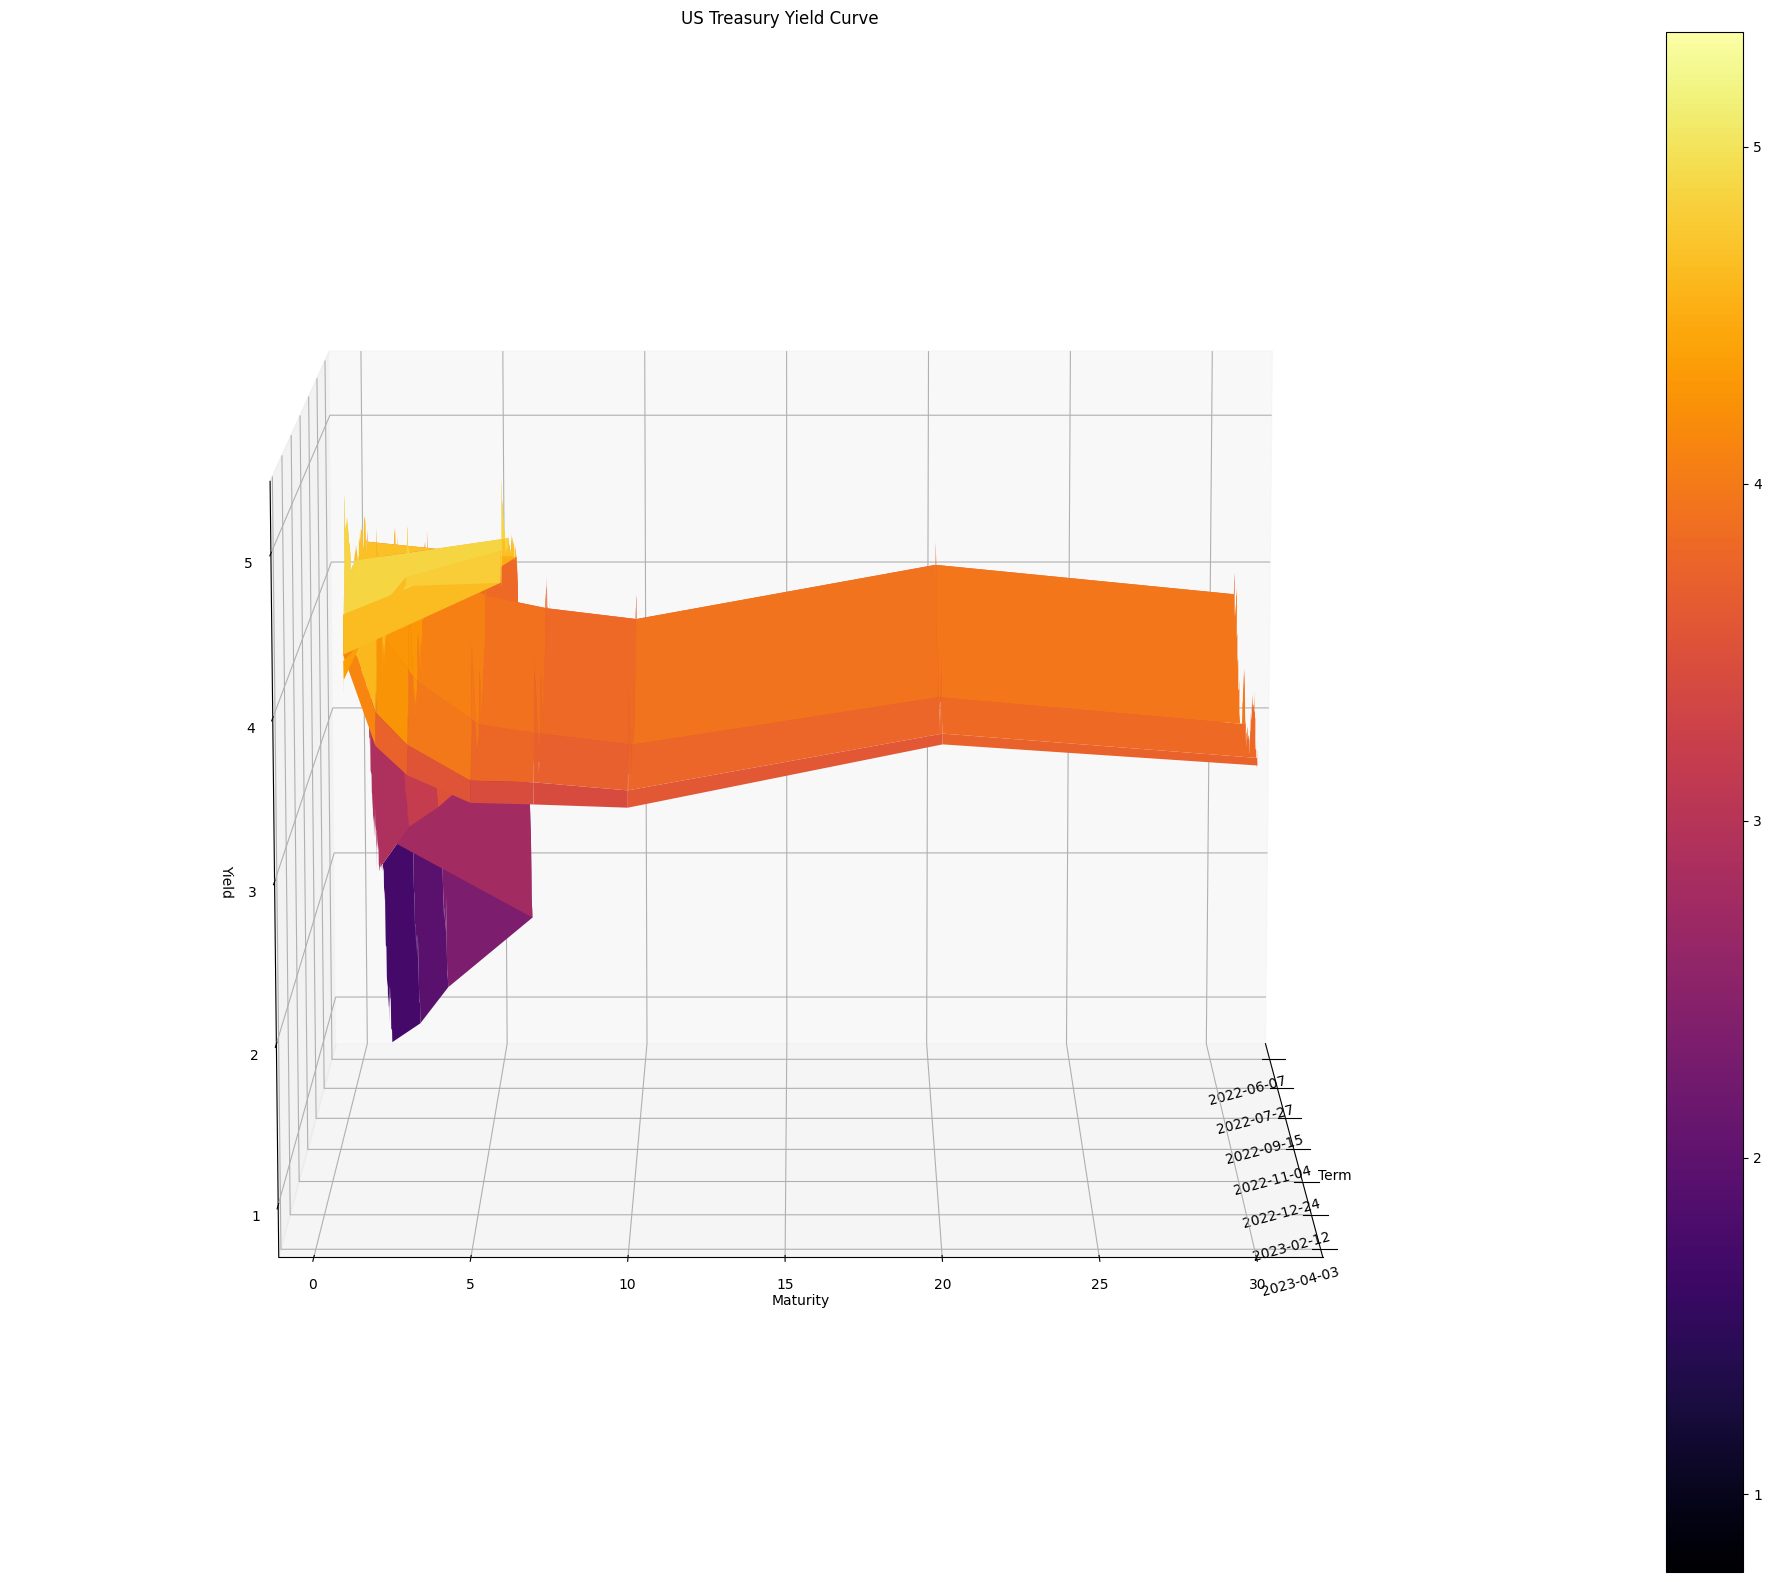

In [17]:
# 手間が最新、奥が古い
# fig = plt.figure(figsize=(15, 10))
fig = plt.figure(figsize=(30, 20))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, z, rstride=50, cstride=1, cmap='inferno', vmin=np.nanmin(z), vmax=np.nanmax(z))
ax.set_title('US Treasury Yield Curve')
ax.set_ylabel('Maturity')
ax.set_zlabel('Yield')
ax.set_xlabel('Term')
# elev y , azim x
ax.view_init(elev=10,azim=360 )
#ax.view_init(elev=230, azim=110)
# SO question
def format_date(x, pos=None):
     return dates.num2date(x).strftime('%Y-%m-%d')

ax.w_xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
for tl in ax.w_xaxis.get_ticklabels():
    tl.set_ha('right')
    tl.set_rotation(15)
fig.colorbar(surf)
plt.show()